## Exercício 1

Siga o tutorial do site [Physics-informed Neural Networks: a simple tutorial with PyTorch](https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a). Neste exemplo, você irá resolver a EDO do resfriamento de uma caneca de café em etapas:

1. Resolva analiticamente a EDO do resfriamento de uma caneca de café. A equação é dada por:

```math
   \frac{dT}{dt} = r(T_{amb} - T)
```
onde $T$ é a temperatura do café, $T_{amb} = 25$ ºC é a temperatura ambiente e $r = 0.005$ $s^{-1}$ é uma taxa de resfriamento.

2. Resolva a EDO usando o método de Runge-Kutta de quarta ordem (RK4) e compare com a solução analítica. Use o comando `scipy.integrate.solve_ivp`.

3. Usando a solução analítica, ou RK4, gere dados sintéticos para treinar a PINN. Cerca de 10 pontos no intervalo de 0 a 200 segundos (veja exemplo no tutorial). Some um ruído gaussiano com média 0 e desvio padrão 0.5 em cada ponto.

4. Tente usar uma NN de regressão simples para ajustar os dados sintéticos e extrapolar para tempos maiores (até 1000 segundos). Compare com a solução analítica. Sabemos que a extrapolação será péssima.

5. Agora, siga o tutorial e implemente a PINN incluindo as restrições físicas na minimização da perda, mas assumindo que conhecemos o valor da taxa $r = 0.005$ 1/s. Compare com a solução analítica e com a NN de regressão simples.

6. Ainda seguindo o tutorial, implemente a PINN sem conhecer o valor da taxa $r$. A rede deve ser capaz de descobrir o valor correto. Compare com a solução analítica e com a NN de regressão simples.

In this notebook, I explore different approaches to solving ordinary differential equations (ODEs): analytical methods, numerical methods, traditional neural networks, and PINNs. The goal is to compare how each method incorporates physical knowledge of the problem, handles extrapolation, and enables the discovery of unknown parameters.

In [1]:
import numpy as np
import tensorflow as tf

The code above creates a time interval and a set of evaluation points that the ODE solver will use to calculate the temperature numerically. It also computes the analytical solution for comparison, and both results are plotted to visualize and compare the trends from the numerical and analytical methods.

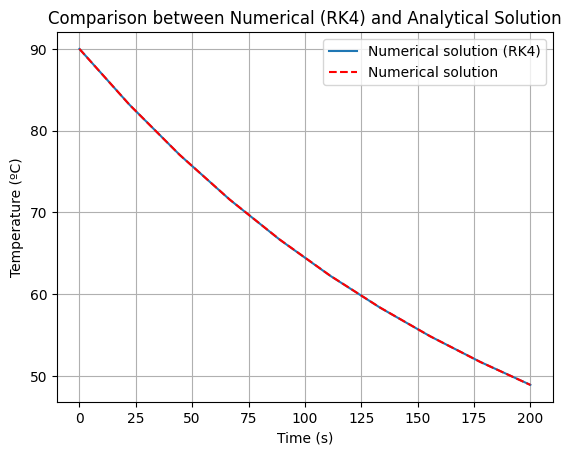

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Defining the ODE: dT/dt = r * (T_amb - T)
def cooling(t, T, r=0.005, T_amb=25):
    return r * (T_amb - T)

# Initial condition and time
T0 = 90
t_interval = (0, 200)  # Time interval
t_eval = np.linspace(0, 200, 10)  # Evaluation points

# Solving the ODE with the Runge-Kutta solver
solution = solve_ivp(cooling, t_interval, [T0], t_eval=t_eval)

plt.plot(solution.t, solution.y[0], label="Numerical solution (RK4)")

# Analytical solution
T_analyt = 25 + (T0 - 25) * np.exp(-0.005 * solution.t)
plt.plot(solution.t, T_analyt, '--', label="Numerical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Comparison between Numerical (RK4) and Analytical Solution")
plt.grid(True)
plt.show()



The neural network model is designed to learn the temperature function $T(t)$. The code above generates points representing the time input, calculates the temperature for each point and its gradient. After the ODE is calculated, the MSE is generated. For this case, the cooling rate ($r$) is given as $R$.

In [4]:
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input."""
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        grads = tape.gradient(outputs, inputs)
    return grads

def physics_loss(model, R, Tenv):
    """The physics loss of the model."""
    # Create collocation points
    time = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  
    time = tf.Variable(time, trainable=True)  

    # Run the collocation points through the network
    temperature = model(time)

    # Get the gradient
    with tf.GradientTape() as tape:
        tape.watch(time)
        dT = tape.gradient(temperature, time)

    # Compute the ODE
    ode = dT - R * (Tenv - temperature)

    # MSE of ODE
    return tf.reduce_mean(tf.square(ode))

In this approach, the cooling rate $r$ is treated as an unknown parameter that the network will attempt to discover during training. The physical loss is computed by generating a set of time points, predicting the corresponding temperatures, and then calculating the gradient of temperature with respect to time.

In [5]:
class Net(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        # Make r a trainable variable
        self.r = tf.Variable(0.0, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        # Define the forward pass (to be implemented based on your architecture)
        pass

def physics_loss_discovery(model, Tenv):
    """Physics loss for discovering the parameter r."""
    # Create collocation points
    time = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  
    time = tf.Variable(time, trainable=True)  

    # Run the collocation points through the network
    temperature = model(time)

    # Compute the gradient of temps with respect to ts
    with tf.GradientTape() as tape:
        tape.watch(time)
        dT = tape.gradient(temperature, time)

    # Use the differentiable parameter r
    residue_ode = model.r * (Tenv - temperature) - dT

    # Return the mean squared error of the PDE residual
    return tf.reduce_mean(tf.square(residue_ode))

Generating synthetic data with noise:

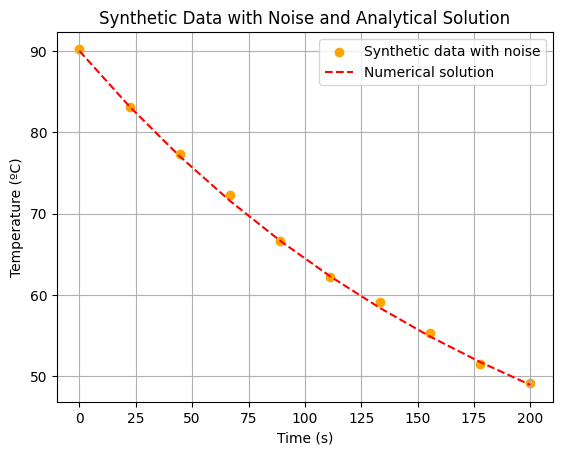

In [6]:
np.random.seed(42)
synthetic_data = T_analyt + np.random.normal(0, 0.5, size=len(solution.t))

plt.scatter(solution.t, synthetic_data, label="Synthetic data with noise", color='orange')
plt.plot(solution.t, T_analyt, '--', label="Numerical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Synthetic Data with Noise and Analytical Solution")
plt.grid(True)
plt.show()


With TensorFlow, it was possible to create a neural network using the analytical solution and the synthetic data as the training set. For the model, I used 4 layers with the ReLU activation function. The model was compiled with a learning rate of 0.007 and trained for 800 epochs.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Converting the data to tensors
X_train = tf.convert_to_tensor(solution.t.reshape(-1, 1), dtype=tf.float32)
y_train = tf.convert_to_tensor(synthetic_data.reshape(-1, 1), dtype=tf.float32)

Epoch 1/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 9764.2646
Epoch 2/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 9176.7051
Epoch 3/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8708.6973
Epoch 4/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 8292.0957
Epoch 5/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 7907.4111
Epoch 6/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7554.2759
Epoch 7/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 7231.1436
Epoch 8/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 6936.0205
Epoch 9/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6666.7354
Epoch 10/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 6421.0713
Epoch 11/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 6196.8384
Epoch 12/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5991.9155
Epoch 13/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 5804.2793
Epoch 14/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 5632.0142
Epoch 15/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75m

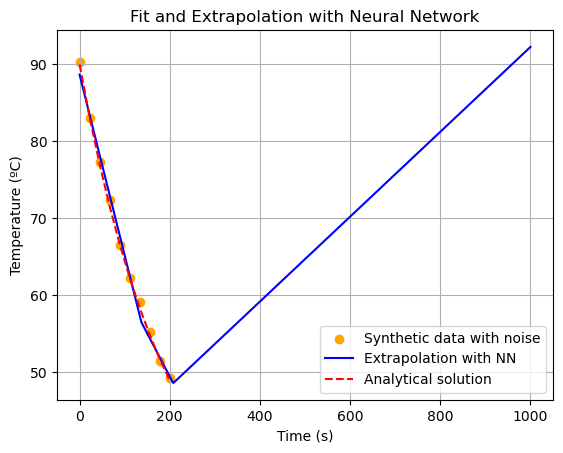

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Converting the data to tensors
X_train = tf.convert_to_tensor(solution.t.reshape(-1, 1), dtype=tf.float32)
y_train = tf.convert_to_tensor(synthetic_data.reshape(-1, 1), dtype=tf.float32)

# Defining the neural network architecture
model = models.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007), loss='mse')

# Training the neural network
model.fit(X_train, y_train, epochs=800, verbose=True)

# Extrapolating the neural network
X_test = np.linspace(0, 1000, 1000).reshape(-1, 1)
y_pred = model.predict(X_test)


plt.scatter(solution.t, synthetic_data, label="Synthetic data with noise", color='orange')
plt.plot(X_test, y_pred, label="Extrapolation with NN", color='blue')
plt.plot(solution.t, T_analyt, '--', label="Analytical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Fit and Extrapolation with Neural Network")
plt.grid(True)
plt.show()

PINN was constructed with 3 hidden layers (15 neurons each, ReLU activation) and 1 output layer; Training minimizes both the data loss (fit to synthetic data) and the physics loss (ODE residual).
After training, the model's predictions are plotted against the noisy data and the analytical solution.

Epoch [0/800], Loss: 4423.5112
Epoch [100/800], Loss: 1531.4471
Epoch [200/800], Loss: 23.1882
Epoch [300/800], Loss: 12.7514
Epoch [400/800], Loss: 7.9187
Epoch [500/800], Loss: 5.3832
Epoch [600/800], Loss: 3.6948
Epoch [700/800], Loss: 2.5222


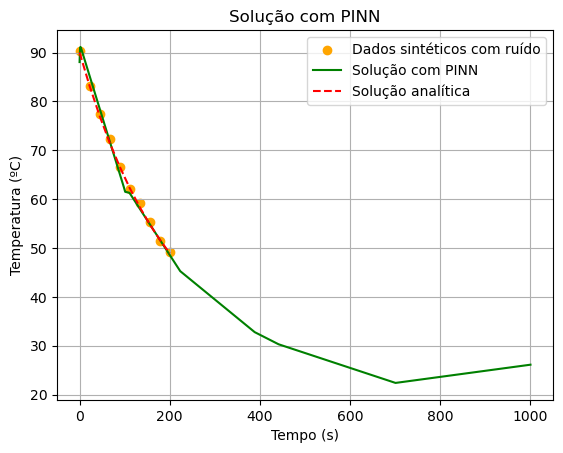

In [ ]:
class PINN(tf.keras.Model):
    def __init__(self, r=0.005):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(15, activation='relu')
        self.dense2 = layers.Dense(15, activation='relu')
        self.dense3 = layers.Dense(15, activation='relu')
        self.dense4 = layers.Dense(1)
        self.r = r

    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        t = self.dense3(t)
        t = self.dense4(t)
        return t

    def physics_loss(self, t, T):
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t)
        T_amb = 25
        # Calculatinhg the physics loss
        loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
        return loss

# Initializing the PINN model
model_pinn = PINN(r=0.005)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)

# Defining the collocation points for the physics loss
t_phys = tf.linspace(0.0, 1000.0, 1000)[:, tf.newaxis]

# Training the PINN model
epochs = 800
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn(X_train)
        loss_data = tf.reduce_mean(tf.square(T_pred - y_train))
        loss_phys = model_pinn.physics_loss(t_phys, model_pinn(t_phys))
        loss = loss_data + 10.0 * loss_phys
    grads = tape.gradient(loss, model_pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")

T_pinn = model_pinn(X_test).numpy()
plt.scatter(solution.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, T_pinn, label="Solução com PINN", color='green')
plt.plot(solution.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Solução com PINN")
plt.grid(True)
plt.show()


The code below is still in development.

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Converting the data to tensors
X_train = tf.convert_to_tensor(solution.t.reshape(-1, 1), dtype=tf.float32)
y_train = tf.convert_to_tensor(synthetic_data.reshape(-1, 1), dtype=tf.float32)

# Defining the neural network architecture
model = models.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007), loss='mse')

# Training the neural network
model.fit(X_train, y_train, epochs=800, verbose=True)

# Extrapolating the neural network
X_test = np.linspace(0, 1000, 1000).reshape(-1, 1)
y_pred = model.predict(X_test)

Epoch 1/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step - loss: 12713.9863
Epoch 2/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 11527.9961
Epoch 3/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10447.7559
Epoch 4/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9467.9746
Epoch 5/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 8582.8418
Epoch 6/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7786.1172
Epoch 7/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7071.3037
Epoch 8/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6502.8525
Epoch 9/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6014.3765
Epoch 10/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5574.0771
Epoch 11/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5177.4106
Epoch 12/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4820.2393
Epoch 13/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4498.7983
Epoch 14/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4209.6768
Epoch 15/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Epoch [0/800], Loss: 400086.0312, r: 0.692148
Epoch [100/800], Loss: 5289.5146, r: 0.646694
Epoch [200/800], Loss: 4834.0713, r: 0.627299
Epoch [300/800], Loss: 4430.5195, r: 0.614537
Epoch [400/800], Loss: 3572.0439, r: 0.601054
Epoch [500/800], Loss: 1397.7550, r: 0.595310
Epoch [600/800], Loss: 1103.1577, r: 0.591299
Epoch [700/800], Loss: 1054.5719, r: 0.584134


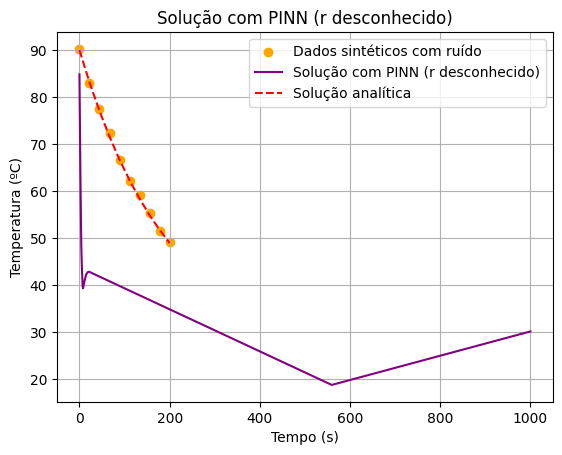

In [13]:
class PINN_r_unknown(tf.keras.Model):
    def __init__(self):
        super(PINN_r_unknown, self).__init__()
        self.dense1 = layers.Dense(15, activation='relu')
        self.dense2 = layers.Dense(15, activation='relu')
        self.dense3 = layers.Dense(15, activation='relu')
        self.dense4 = layers.Dense(1)
        # Parâmetro livre, pode ser negativo, mas r será sempre positivo
        self.r_raw = self.add_weight(
            name='r_raw',
            shape=(),
            initializer=tf.constant_initializer(0.005),
            trainable=True,
            dtype=tf.float32
        )
        
    @property
    def r(self):
        # Softplus garante r > 0
        return tf.nn.softplus(self.r_raw)
        
    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        t = self.dense3(t)
        t = self.dense4(t)
        return t

    def physics_loss(self, t, T):
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t)
        T_amb = 25
        # Use self.r (sempre positivo)
        loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
        return loss
    

# Inicializando e treinando a PINN
model_pinn_r_unknown = PINN_r_unknown()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)

# Defina os pontos de collocation para a physics loss (domínio físico)
t_phys = tf.linspace(0.0, 1000.0, 1000)[:, tf.newaxis]

# Treinando a PINN
epochs = 800
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn_r_unknown(X_train)
        # Physics loss precisa ser calculada DENTRO do tape!
        loss_data = tf.reduce_mean(tf.square(T_pred - y_train))
        loss_phys = model_pinn_r_unknown.physics_loss(t_phys, model_pinn_r_unknown(t_phys))
        loss = loss_data + 20.0 * loss_phys
    grads = tape.gradient(loss, model_pinn_r_unknown.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn_r_unknown.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}, r: {model_pinn_r_unknown.r.numpy():.6f}")

T_pinn_r_unknown = model_pinn_r_unknown(X_test).numpy()
plt.scatter(solution.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, T_pinn_r_unknown, label="Solução com PINN (r desconhecido)", color='purple')
plt.plot(solution.t, T_analyt, '--', label="Solução analítica", color='red')
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Solução com PINN (r desconhecido)")
plt.grid(True)
plt.show()
    